In [215]:
import urllib.request
import pandas as pd
import statsmodels.api as sm
import unicodedata
from itertools import cycle 
import re
import time
import numpy as np
import pylab
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
from datetime import datetime, timedelta 
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)
path = 'C:/Users/erler/OneDrive/Documents/Random Data Sets/Basketball/Kaggle/'

# Load and format data

In [216]:
drafts = pd.read_csv(path+'Draft_table.csv')
drafts.DOB = pd.to_datetime(drafts.DOB)

Predraft_stats = pd.read_csv(path+'Pre_NBA_game_logs.csv')
Predraft_stats.Rk = pd.to_numeric(Predraft_stats.Rk)
Predraft_stats[Predraft_stats.loc[:,'FG':'PTS'].columns.values] = Predraft_stats[Predraft_stats.loc[:,'FG':'PTS'].columns.values].astype('float64')
Predraft_stats = Predraft_stats.convert_dtypes(infer_objects=True)
Predraft_stats.Date = Predraft_stats.Date.astype('datetime64')
Predraft_stats.DOB = pd.to_datetime(Predraft_stats.DOB)
#force int64 to float64 for cooperation with statsmodel package
for i in Predraft_stats.columns:
    if Predraft_stats[i].dtype == 'Int64':
        Predraft_stats[i] = Predraft_stats[i].astype('float64')
        
NBA_stats = pd.read_csv(path+'NBA_game_logs.csv')
NBA_stats.MP = pd.to_timedelta(NBA_stats.MP)
NBA_stats.Date = pd.to_datetime(NBA_stats.Date)
NBA_stats.DOB = pd.to_datetime(NBA_stats.DOB)
NBA_stats.Years_pro = round(NBA_stats.Years_pro,0)

C:\Users\erler\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':


# Aggregate games data and connect pre NBA stats to NBA stats

The code below starts by electing to only include players which have shot a minimum of n=100 3pt shots in each pre NBA leagues as well as the players's first NBA seasons** and at least 100 pre NBA free throw attempts. The code then produces aggregate statistics for each player in each leagues much like a pivot table would in excel. This results in one dataset with 240 players which has one row for each player and includes both preNBA and NBA 3pt shooting percentage.

** I chose the first 4 NBA seasons because this is the rookie contract period in the NBA. With the amount of attrition in the NBA it's somewhat irrelevant for the drafting team how a player performs in the second half of their career as they may not be with their original team.

In [217]:
n=100 #set minimum number of three point attempts required to be included in the sample
threes_pre = Predraft_stats.groupby(['Player', 'DOB']).agg({'3P':sum, '3PA':sum, 
        '2P':sum, '2PA':sum, 'FT':sum, 'FTA':sum})#.sort_values(by='PTS', ascending=False)
threes_pre['pre3%'] = threes_pre['3P']/threes_pre['3PA']
threes_pre['2P%'] = threes_pre['2P']/threes_pre['2PA']
threes_pre['pre_FT%'] = threes_pre['FT']/threes_pre['FTA']
#threes_pre.sort_values(by='3P%', ascending=False).head(10)

threes_nba = NBA_stats.loc[NBA_stats['Years_pro']<=4].groupby(['Player', 'DOB']).agg({'3P':sum, '3PA':sum, 'Years_pro':'max'})#.sort_values(by='PTS', ascending=False)
threes_nba['nba3%'] = threes_nba['3P']/threes_nba['3PA']
#threes_nba.sort_values(by='3P%', ascending=False)

three = pd.merge(threes_nba, threes_pre, left_index=True, right_index=True, suffixes=('_nba', '_pre'))
#three = three.rename(columns={'nba3%': 'nba3%', 'pre3%':'pre3%'})

three['%_var']=three['nba3%']-three['pre3%']

three = three.merge(drafts[['Player', 'DOB','Pro_height', 'Pk']], left_index=True, right_index=False, on=['Player', 'DOB'])

three = three.loc[(three['3PA_nba']>n)&(three['FT']>n)&(three['3PA_pre']>n)&(three.isna().sum(axis=1)==0)]
three['2PA'] = three['2PA'].astype(float)
three['FTA'] = three['FTA'].astype(float)
three['3PA_pre'] = three['3PA_pre'].astype(float)

three.shape

(240, 18)

In [218]:
three.head()

,Player,DOB,3P_nba,3PA_nba,Years_pro,nba3%,3P_pre,3PA_pre,2P,2PA,FT,FTA,pre3%,2P%,pre_FT%,%_var,Pro_height,Pk
262,aaron-brooks,1985-01-14,455,1253,3.0,0.363128,171.0,456.0,268.0,544.0,271.0,325.0,0.375000,0.492647,0.833846,-0.011872,72.0,26
919,aaron-holiday,1996-09-30,148,407,2.0,0.363636,180.0,427.0,296.0,631.0,311.0,391.0,0.421546,0.469097,0.795396,-0.057909,72.0,23
834,abdel-nader,1993-09-25,104,303,4.0,0.343234,128.0,420.0,304.0,686.0,215.0,294.0,0.304762,0.443149,0.731293,0.038472,77.0,58
247,acie-law,1985-01-25,28,118,3.0,0.237288,80.0,195.0,333.0,638.0,234.0,305.0,0.410256,0.521944,0.767213,-0.172968,75.0,11
179,adam-morrison,1984-07-19,124,377,3.0,0.328912,95.0,255.0,368.0,680.0,306.0,400.0,0.372549,0.541176,0.765000,-0.043637,80.0,3


# Understanding distribution of percentages

In the plot below we see the overlapping distributions of NBA 3pt shooting percentages and Pre NBA 3pt shooting percentages. Although not a perfect normal distribution curve it appears to be quite normal considering we have 240 players in our sample set which has been limited to players who attempted at least 100 three point shots prior to the NBA and in the NBA. However, we will take more formal measures of the normality of the distribution to see if we can invoke the central limit theorum when choosing a statistical test for hypothesis testing.

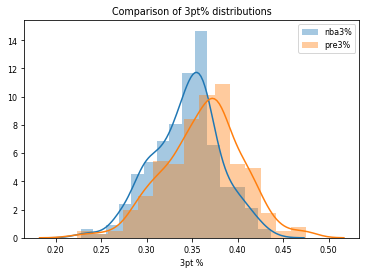

<Figure size 432x288 with 0 Axes>

In [238]:
sns.distplot(three['nba3%'].dropna(), label='nba3%', bins = 15)
sns.distplot(three['pre3%'].dropna(), label='pre3%', bins = 15)
plt.gca().set(title='Comparison of 3pt% distributions', xlabel='3pt %')
plt.legend()
plt.show()
plt.savefig(path+'hist.png')

# Tests for a normality in the distribution of three point percentages

### QQ Plot (Quantile Quantile)

In a QQ plot, the we look to see that the plotted values stick closely to the red line which represents a perfectly normal distribution. Both distributions appear to follow a reasonably normal distribution.

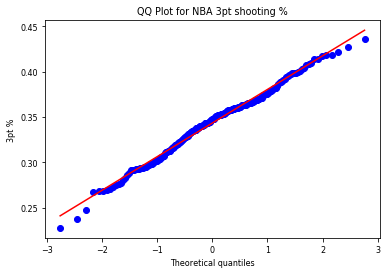

In [220]:
stats.probplot(three['nba3%'], dist='norm', plot=pylab) 
plt.gca().set(title='QQ Plot for NBA 3pt shooting %', ylabel='3pt %')
pylab.show()

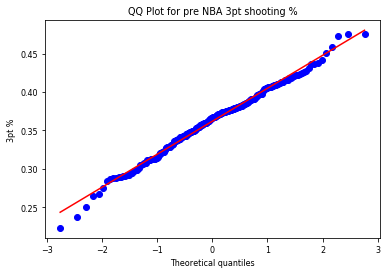

In [221]:
stats.probplot(three['pre3%'], dist='norm', plot=pylab) 
plt.gca().set(title='QQ Plot for pre NBA 3pt shooting %', ylabel='3pt %')
pylab.show()

### Shapiro-wilks test (Most highly recommended test for normality)

The shapiro wilks test is a hypothisis test which compares a p-value to an alpha value, which is normally .05. In this case the null hypothesis is that the distributions are normally distributed. We would be suprised to see a p-value below .05 and would reject the null hypothesis if observed. Below we have p-values of .135 and .265 which suggests that there is not enough evidence to reject the null hypothesis, that these populations are not normally distributed. 

In [222]:
stat, pval_nba3 = stats.shapiro(three['nba3%'])
print('p-value NBA 3pt%: ', pval_nba3)

stat, pval_pre3 = stats.shapiro(three['pre3%'])
print('p-value pre NBA 3pt%: ', pval_pre3)

p-value NBA 3pt%:  0.13526523113250732
p-value pre NBA 3pt%:  0.2653345763683319


# Analysis of the variances between pre NBA and NBA 3pt shooting

There have been 240 players between 2003 and 2020 who have attempted at least 100 threes both pre NBA and in the NBA in their first 4 NBA seasons. Of these players 68% have regressed in percentage. The ave average regression is 1.87% from 36.2% in college to 34.32% in the NBA. 

Of those 164 players who regressed, they had a mean pre NBA three point percentage of 37.7% and decreased by an average of 4.2% to 33.5%. Of those who improved, they had a mean three point percentage of 32.9% and increased by an average of 3.3% to 36.2%.

This leads me to a hypothesis that perhaps those who shot the 3 at a high percentage in college were lucky to some extent and this doesn't necessarly mean they will be able to sustain this percentage in the pros. And vice-versa, those who shot poorly and college may be more likely to improve in the pros. I will also examine the reverse vantage point by seperating players into two groups based on whether they shot above the NBA three point average or below. I will then see how their college percentages compare to their NBA percentages. Ultimately, we want to understand if players with low pre-nba 3pt percentages should be avoided and if those with high pre-nba 3pt percentages will convert to high percentage nba 3pt shooters. 

In [223]:
improved = three.loc[three['%_var']>=0]
regressed = three.loc[three['%_var']<0]

print('players:', len(three))
print('% who regressed: {:.2%}'.format(len(regressed)/len(three)))
print('Ave 3% NBA: {:.2%}'.format(three['nba3%'].mean()))
print('Ave 3% Pre_NBA: {:.2%}'.format(three['pre3%'].mean()))
print('Ave Regression: {:.2%}'.format(three['pre3%'].mean()-three['nba3%'].mean()))

players: 240
% who regressed: 68.33%
Ave 3% NBA: 34.32%
Ave 3% Pre_NBA: 36.20%
Ave Regression: 1.87%


# Paired T-Test and confidence of mean difference

In this section, I will answer the question as to whether or not there enough evidence to prove that players generally shoot the 3pt shot less successfully than in the NBA than in the NCAA or international league play. While we know that on average players make 1.87% less of their 3pt shots, the mean difference is not necessarily a robust measure to prove this difference. Therefore, we will use a paired t-test to assess this difference and provide a range of possible mean variances at the 95% confidence level. A paired t-test is chosen because each player has an observation in each pre NBA and NBA. 

### Assumptions

- Dependent variable is countinuous: Yes

- Samples are independent: Yes, two completely different leagues.

- The variances between the shooting percentages follow a normal distribution when assessed as a collective. Below is a histogram of the variance of shooting percentages between pre NBA and the NBA. It's clear the majority of players declined and these variances are normally distributed. The shapiro-wilks tests confirms this with a p-value of .38, which is not enough to reject the null hypothesis. Had the normality assumption been violated the  Wilcoxon signed-rank Test could be used.

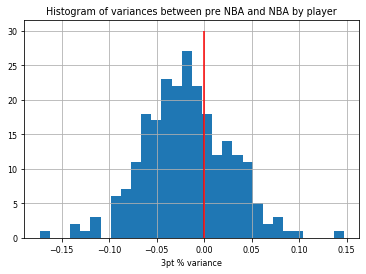

In [224]:
three['%_var']
three['%_var'].hist(bins=30)
plt.gca().set(title='Histogram of variances between pre NBA and NBA by player', xlabel='3pt % variance')
plt.vlines(0, ymin=0, ymax=30, colors='red')

In [225]:
stat, pval = stats.shapiro(three['%_var'])
print('p-value variances by player for 3pt%: ', pval)

p-value variances by player for 3pt%:  0.3797999620437622


### Executing the paired t-test

The p-value is well below the .05 alpha threshold for rejecting the null hypothesis. Therefore, we conclude that there is a difference in populations. At the 95% confidence level, we estimate that NBA 3 point shooting percentage is between 1.6% and 2.2% lower than observed for draft selections in their NCAA and overseas league play.  

In [226]:
stat, pval = stats.ttest_rel(a=three['3P_nba'], b=three['3P_pre'])
print('p-value: ', pval)

p-value:  2.7781963268912806e-22


In [227]:
mean_variance = three['%_var'].mean()
standard_deviation = three['%_var'].std()
n = len(three['%_var'])
print('mean difference', round(three['%_var'].mean(),3))
print('lower bound', round(mean_variance+standard_deviation/np.sqrt(n), 3))
print('upper bound', round(mean_variance-standard_deviation/np.sqrt(n), 3))

mean difference -0.019
lower bound -0.016
upper bound -0.022


# Is pre NBA 3pt% a good predictor of NBA 3pt%?

In [228]:
print('Correlation between pre NBA and NBA: {:.3}'.format(three[['nba3%', 'pre3%']].corr(method='pearson').iloc[0,1]))

Correlation between pre NBA and NBA: 0.356


Right out of the gates we see that at .356, pre NBA 3pt% has a relatively weak correlation with NBA 3pt% performance. But what does that mean exactly? The graph below plots the 3pt% of pre NBA players from lowest to highest percentages (blue) along with how they performed in the NBA (orange dots) and the moving average of these NBA 3pt% actuals (orange line). Notice that there is only a slight upward trend in the moving average for NBA 3pt% as it is compared with the increasing pre NBA performance. 

This means that how a player shoots in the NCAA and overseas provides little assurance as to how they will shoot the ball from beyond the 3pt line in the NBA.

At around 33% we see a cross over point which means that if a player shot less than 33% pre NBA it's likely they will increase their percentage in the NBA and vice versa. 

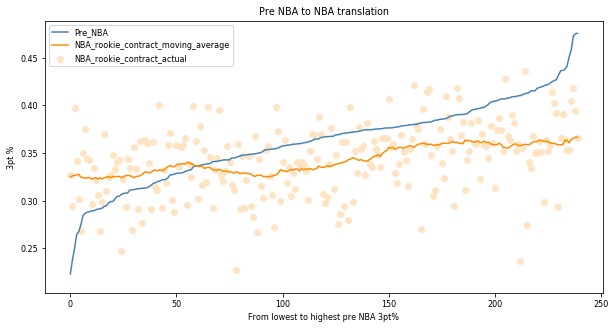

In [229]:
window=40

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
df = three[['pre3%', 'nba3%']].sort_values(by='pre3%').reset_index(drop=True).reset_index()
nba = df['nba3%'].rolling(window=window, center= True, min_periods=1).mean()


plt.scatter(x=df['index'], y=df['nba3%'], color='bisque', label='NBA_rookie_contract_actual')
plt.plot(df['pre3%'], label='Pre_NBA', color='steelblue')
plt.plot(nba, label='NBA_rookie_contract_moving_average', color='darkorange')
plt.gca().set(title='Pre NBA to NBA translation', ylabel='3pt %', xlabel='From lowest to highest pre NBA 3pt%')
plt.legend();

# If Pre_NBA 3pt % isn't a good predictor, what is?

Here I will examine possible predictors for association with NBA 3pt%. Here we see that pre NBA free throw percentage has a stronger correlation with NBA 3pt% at .439. Additionally, there is a weak correlation between the number of 3pt attempts a player took in college vs NBA 3pt%. This makes sense given that a player would be allowed more attempts if the team has confidence in their ability to shoot the three.  

In [230]:
three[['nba3%', 'pre3%', '2P%', 'pre_FT%', 'Pk', '2PA', 'FTA', '3PA_pre', 'Pro_height']].corr()['nba3%']

nba3%         1.000000
pre3%         0.356082
2P%          -0.011514
pre_FT%       0.438803
Pk            0.022045
2PA           0.012329
FTA          -0.005662
3PA_pre       0.315754
Pro_height   -0.042994
Name: nba3%, dtype: float64

# Multiple-linear regression

Here I will do a make a quick multiple linear model of this data using the three correlated variables previously identified. First, I will check that the variables do not have multicollinearity. This is when independent variables have a correlation greater than .7. In this case, .52 is the highest and I am not concerned by this.

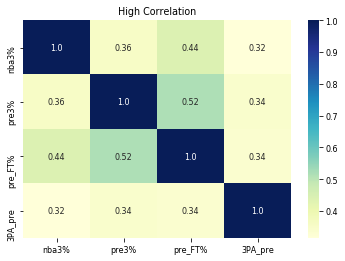

In [231]:
num_correlation = three[['nba3%', 'pre3%','pre_FT%', '3PA_pre']].corr()
plt.title('High Correlation')
plt.rc('font', size=8) 
sns.heatmap(data=num_correlation, cmap="YlGnBu", annot=True, fmt=".2")

In [232]:
import statsmodels.api as sm
ols_model = sm.OLS(three['nba3%'], three[['pre3%', 'pre_FT%', '3PA_pre']])
ols_results = ols_model.fit()
print(ols_results.summary())

                                 OLS Regression Results                                
Dep. Variable:                  nba3%   R-squared (uncentered):                   0.990
Model:                            OLS   Adj. R-squared (uncentered):              0.990
Method:                 Least Squares   F-statistic:                              7900.
Date:                Fri, 29 Jan 2021   Prob (F-statistic):                   3.80e-237
Time:                        16:58:11   Log-Likelihood:                          468.52
No. Observations:                 240   AIC:                                     -931.0
Df Residuals:                     237   BIC:                                     -920.6
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

# Error distribution

In any model it's important to verify that the residuals are equally distributed. The model appears to satisfy this requirement in the plot below. 

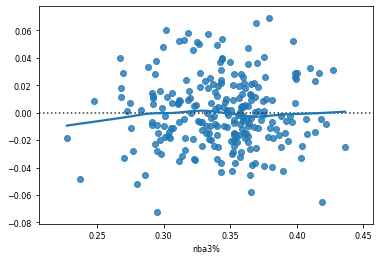

In [233]:
sns.residplot(x=three['nba3%'], y=ols_results.resid, lowess=True)

# Results

The median absolute error of each prediction 3pt% prediction 2.13% points. This equates to a correlation .475, 
which is slightly better than .439 correlation from if we had made predictions using only free throw percentage.

All in all, we learned that it's more important to judge a future NBA 3 point shooter by their prior performance shooting free throws than it is their 3 point shot... oddly enough. Additionally, given the relatively weak ability to predict 3 point shooting percentage. It would be unwise to place too much emphasis in a player's shooting ability pre NBA. There is a lot of evidence suggesting that low performers can improve and high performers will not always sustain this ability. Perhaps their are other traits which are easier to predict how they translate to the NBA than 3 point shooting. Thanks for reading and I hope you enjoyed it.

In [236]:
sm.tools.eval_measures.medianabs(ols_results.fittedvalues, three['nba3%']) #median absolute error

0.0213238452701692

In [235]:
np.corrcoef(ols_results.fittedvalues, three['nba3%'])[1][0] #correlation

0.47547847777253915